In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image
import requests
import json
import matplotlib.pyplot as plt
import cv2

json_url = 'https://gharizap.github.io/JSONResep/dataresep.json'
labels_url = 'https://gharizap.github.io/JSONResep/labels.txt'

In [ ]:
# Fungsi untuk memuat labels dari labels.txt
def load_labels(labels_url):
    response = requests.get(labels_url)
    labels = response.text.splitlines()
    return labels

# Muat labels
labels = load_labels(labels_url)
labels

['Ayam Betutu',
 'Beberuk Terong',
 'Coto Makassar',
 'Gudeg',
 'Kerak Telor',
 'Mie Aceh',
 'Nasi Kuning',
 'Nasi Pecel',
 'Papeda',
 'Pempek',
 'Peuyeum',
 'Rawon',
 'Rendang',
 'Sate Madura',
 'Serabi',
 'Soto Banjar',
 'Soto Lamongan',
 'Tahu Sumedang']

In [ ]:
# Fungsi untuk memproses gambar
def process_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)
    img = np.array(img, dtype=np.float32)
    img = np.expand_dims(img, axis=0)
    return img

# Fungsi untuk menjalankan inferensi
def run_inference(interpreter, input_data):
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    return output_data

In [ ]:
# Mengambil gambar dan menjalankan inferensi
IMAGE_PATH = 'drive/MyDrive/Testing_model/test1.jpeg'
input_data = process_image(IMAGE_PATH)

interpreter = tf.lite.Interpreter(model_path='drive/MyDrive/Testing_model/food_detection.tflite')
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

output_data = run_inference(interpreter, input_data)

# Mengambil label hasil inferensi
predicted_index = np.argmax(output_data)
predicted_label = labels[predicted_index].strip()

# Menampilkan hasil inferensi
print(f"Predicted Label: {predicted_label}")

Predicted Label: Beberuk Terong


In [ ]:
# Mengambil data resep dari JSON
def fetch_recipe(json_url, label):
    response = requests.get(json_url)
    recipes_data = response.json()

    # Memastikan recipes diambil dengan benar dari struktur JSON
    if 'recipes' in recipes_data:
        recipes = recipes_data['recipes']
    else:
        print("Key 'recipes' not found in JSON data.")
        return None

    # Mengambil resep yang sesuai dengan label
    recipe = next((item for item in recipes if item["name"].strip().lower() == label.lower()), None)
    return recipe

# Menampilkan resep berdasarkan hasil inferensi
raw_recipe = fetch_recipe(json_url, predicted_label)

if raw_recipe:
    recipe = {
        'Nama': raw_recipe['name'],
        'Bumbu Halus': raw_recipe['bumbu_halus'],
        'Bumbu Kasar': raw_recipe['bumbu_kasar'],
        'Langkah-langkah': raw_recipe['langkah_langkah']
    }

    recipe_str = f"Recipe for {predicted_label}:\n"
    recipe_str += f"Nama: {recipe['Nama']}\n"
    recipe_str += "Bumbu Halus:\n"
    for item in recipe['Bumbu Halus']:
        recipe_str += f"  - {item}\n"
    recipe_str += "Bumbu Kasar:\n"
    for item in recipe['Bumbu Kasar']:
        recipe_str += f"  - {item}\n"
    recipe_str += "Langkah-langkah:\n"
    for step in recipe['Langkah-langkah']:
        recipe_str += f"  - {step}\n"
else:
    recipe = None
    recipe_str = f"No recipe found for {predicted_label}"

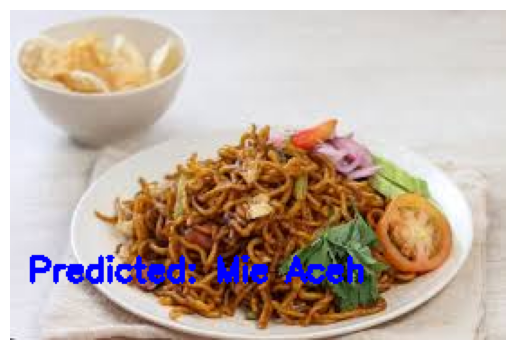

Recipe for Mie Aceh:
Nama: Mie Aceh
Bumbu Halus:
  - 4 siung bawang putih
  - 8 siung bawang merah
  - 5 buah cabai merah
  - 1 sdt jintan
  - 2 cm kunyit
  - 2 cm jahe
Bumbu Kasar:
  - 200 gram mie kuning
  - 100 gram daging sapi
  - 100 gram udang
  - 2 lembar daun salam
  - 2 batang serai
  - Air secukupnya
  - Garam secukupnya
Langkah-langkah:
  - Rebus mie kuning hingga matang, tiriskan.
  - Haluskan bumbu halus, tumis hingga harum.
  - Masukkan daging sapi, udang, daun salam, dan serai, masak hingga daging matang.
  - Tambahkan air dan mie kuning, aduk rata.
  - Tambahkan garam sesuai selera, masak hingga bumbu meresap, angkat dan sajikan.



In [ ]:
# Fungsi untuk menampilkan hasil deteksi di gambar
def display_results(image_path, output_data, labels, predicted_label, threshold=0.5):
    img = cv2.imread(image_path)
    h, w, _ = img.shape

    for detection in output_data:
        if detection[0] > threshold:  # Threshold untuk menampilkan deteksi
            ymin, xmin, ymax, xmax = detection[1], detection[2], detection[3], detection[4]
            xmin, xmax, ymin, ymax = int(xmin * w), int(xmax * w), int(ymin * h), int(ymax * h)
            img = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
            label = labels[int(detection[5])]
            img = cv2.putText(img, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    img = cv2.putText(img, f"Predicted: {predicted_label}", (10, 150), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Hide axes
    plt.show()

display_results(IMAGE_PATH, output_data, labels, predicted_label)
print(recipe_str)